In [1]:
using PyPlot, SeisPlot
using FFTW
using LinearAlgebra
using DSP, MAT
using Random
using SeisProcessing

In [2]:
include("BlendOpFreq.jl")
include("FastHankelMultply.jl")
include("Hankelization.jl")
include("Anti_Diagonal_Average.jl")
include("SeisFSSA.jl")
include("SeisMSSA.jl")
include("SeisRandomQR.jl")
include("Ricker.jl")
include("SeisLocal.jl")
include("SeisLocalPatch.jl")
include("SeisRadontimePara.jl")
include("ApplyTaper.jl")
include("SeisUnlocal.jl")

SeisUnlocal

In [3]:
file = matopen("FD.mat")
data = read(file, "C"); # note that this does NOT introduce a variable ``varname`` into scope
close(file)

D   = data[:,101:200,51:300];
(nt,nr,ns) = size(D)
dt = 0.004
Random.seed!(1234)
################# FOR blending_forward_adjoint2 Test [nt,nr,ns]##########################
QD0 = (norm(D))^2;

jtime = rand(ns)*0.5*nt*dt ;

b = BlendOpFreq(D,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
D1 = BlendOpFreq(b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)


4001×100×250 Array{Float64,3}:
[:, :, 1] =
  1.4485e-8   -3.33517e-9   -1.19925e-8  …   1.88031e-8  -4.8852e-9 
 -1.44708e-8   3.33189e-9    1.19808e-8     -1.87846e-8   4.88041e-9
  1.44566e-8  -3.32862e-9   -1.1969e-8       1.87662e-8  -4.87562e-9
 -1.44424e-8   3.32535e-9    1.19573e-8     -1.87478e-8   4.87083e-9
  1.44282e-8  -3.32208e-9   -1.19455e-8      1.87293e-8  -4.86604e-9
 -1.4414e-8    3.31881e-9    1.19338e-8  …  -1.87109e-8   4.86125e-9
  1.43999e-8  -3.31555e-9   -1.1922e-8       1.86925e-8  -4.85647e-9
 -1.43857e-8   3.31228e-9    1.19103e-8     -1.86741e-8   4.85169e-9
  1.43715e-8  -3.30902e-9   -1.18986e-8      1.86557e-8  -4.84691e-9
 -1.43573e-8   3.30575e-9    1.18868e-8     -1.86373e-8   4.84213e-9
  1.43432e-8  -3.30249e-9   -1.18751e-8  …   1.86189e-8  -4.83736e-9
 -1.4329e-8    3.29923e-9    1.18634e-8     -1.86006e-8   4.83258e-9
  1.43149e-8  -3.29597e-9   -1.18517e-8      1.85822e-8  -4.82781e-9
  ⋮                                      ⋱                  

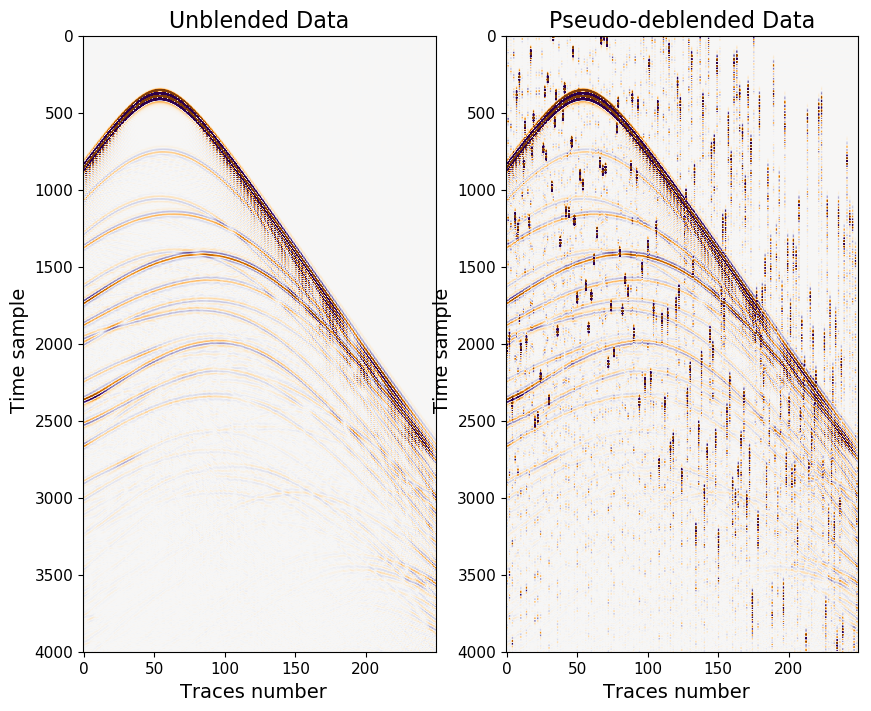

PyObject <matplotlib.image.AxesImage object at 0x7f21dbb70450>

In [4]:
close("all")
vm=0.5
figure(1, figsize=(10, 8))
subplot(121);SeisPlotTX(D[:,5,:], title="Unblended Data", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(122);SeisPlotTX(D1[:,5,:], title="Pseudo-deblended Data", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [5]:
param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>1000,:it_WO=>20,:dx1=>1,:ix1_WL=>50,:ix1_WO=>20,:x1min=>1,:x1max=>100);

param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>250);


In [6]:
lamda = 0.5
rk    = 6

D3    = copy(D1);
D4    = copy(D1);
@time for i = 1:20
    global D3
    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp3 = BlendOpFreq(b3-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z3 = D3 - lamda.*Dtemp3;

    param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>1000,:it_WO=>20,:dx1=>1,:ix1_WL=>30,:ix1_WO=>20,:x1min=>1,:x1max=>100);
    param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>250);
    (zout,Minval,Maxval) = SeisLocal(z3; param1...,param2...)
    pzout = zeros(eltype(zout),size(zout))
    if rem(i,5)==0
        global rk
        rk = rk+1
    end
    for ip = 1 : size(zout,ndims(zout))
        # pzout[:,:,:,ip] = SeisFSSA(zout[:,:,:,ip],rk,0.004,1.0,125.0; order="3D")
        pzout[:,:,:,ip] = SeisRandomQR(zout[:,:,:,ip], rk; dt=0.004, flow=1.0, fhigh=125.0, order="3D")
    end

    # D3 = SeisFSSA(z3,rk,0.004,1.0,125.0; or der="3D")

    D3 = SeisUnlocal(pzout,Minval,Maxval,nt; param1...,param2...)

    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e3 = b - b3
    error3 = dot(vec(e3), vec(e3));
    println(error3)
end
QD3 = (norm(D-D3))^2
QS3 = 10*log10(QD0/QD3)
println(QS3)

Number of patches= 120
885461.2778171416
Number of patches= 120
589316.6594632586
Number of patches= 120
389908.96681382175
Number of patches= 120
280745.8857216627
Number of patches= 120
180006.15069709477
Number of patches= 120
136791.11696161932
Number of patches= 120
113702.62497817064
Number of patches= 120
100636.68136752096
Number of patches= 120
93298.22219842227
Number of patches= 120
64119.65916008421
Number of patches= 120
53303.21184352958
Number of patches= 120
47876.42624946912
Number of patches= 120
44509.80861235369
Number of patches= 120
42682.111093636566
Number of patches= 120
34396.34175408675
Number of patches= 120
31343.711950207307
Number of patches= 120
29638.00837100485
Number of patches= 120
28652.2102955945
Number of patches= 120
28117.99294826767
Number of patches= 120
22242.117957911374
9607.602662 seconds (30.84 G allocations: 12.884 TiB, 9.67% gc time)
22.954333970799752


In [7]:
@time for i = 1:20
    global D4
    b4 = BlendOpFreq(D4,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp4 = BlendOpFreq(b4-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z4 = D4 - lamda.*Dtemp4;

    param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>1000,:it_WO=>20,:dx1=>1,:ix1_WL=>30,:ix1_WO=>20,:x1min=>1,:x1max=>100);
    param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>250);
    (zout4,Minval4,Maxval4) = SeisLocal(z4; param1...,param2...)
    pzout4 = zeros(eltype(zout4),size(zout4))
    if rem(i,5)==0
        global rk
        rk = rk+1
    end
    for ip = 1 : size(zout4,ndims(zout4))
        pzout4[:,:,:,ip] = SeisFSSA(zout4[:,:,:,ip],rk,0.004,1.0,125.0; order="3D")
        # pzout[:,:,:,ip] = SeisRandomQR(zout[:,:,:,ip], rk; dt=0.004, flow=1.0, fhigh=125.0, order="3D")
    end

    # D3 = SeisFSSA(z3,rk,0.004,1.0,125.0; or der="3D")

    D4 = SeisUnlocal(pzout4,Minval4,Maxval4,nt; param1...,param2...)

    b4 = BlendOpFreq(D4,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e4 = b - b4
    error4 = dot(vec(e4), vec(e4));
    println(error4)
end
QD4 = (norm(D-D4))^2
QS4 = 10*log10(QD0/QD4)
println(QS4)


Number of patches= 120
465017.6767147028
Number of patches= 120
290075.4487715723
Number of patches= 120
176138.70177387577
Number of patches= 120
111724.94748391616
Number of patches= 120
69499.8852803769
Number of patches= 120
49582.74154571736
Number of patches= 120
37765.86892354833
Number of patches= 120
30330.838583289187
Number of patches= 120
25467.866727836277
Number of patches= 120
19235.447971064106
Number of patches= 120
16576.438128717396
Number of patches= 120
14845.137350494833
Number of patches= 120
13669.485628739856
Number of patches= 120
12807.895627396545
Number of patches= 120
11183.934988954226
Number of patches= 120
10514.856868384177
Number of patches= 120
10073.172559703862
Number of patches= 120
9795.150002394881
Number of patches= 120
9581.559953327542
Number of patches= 120
8339.942571910753
24680.503307 seconds (56.70 G allocations: 24.427 TiB, 7.83% gc time)
25.856425456900126


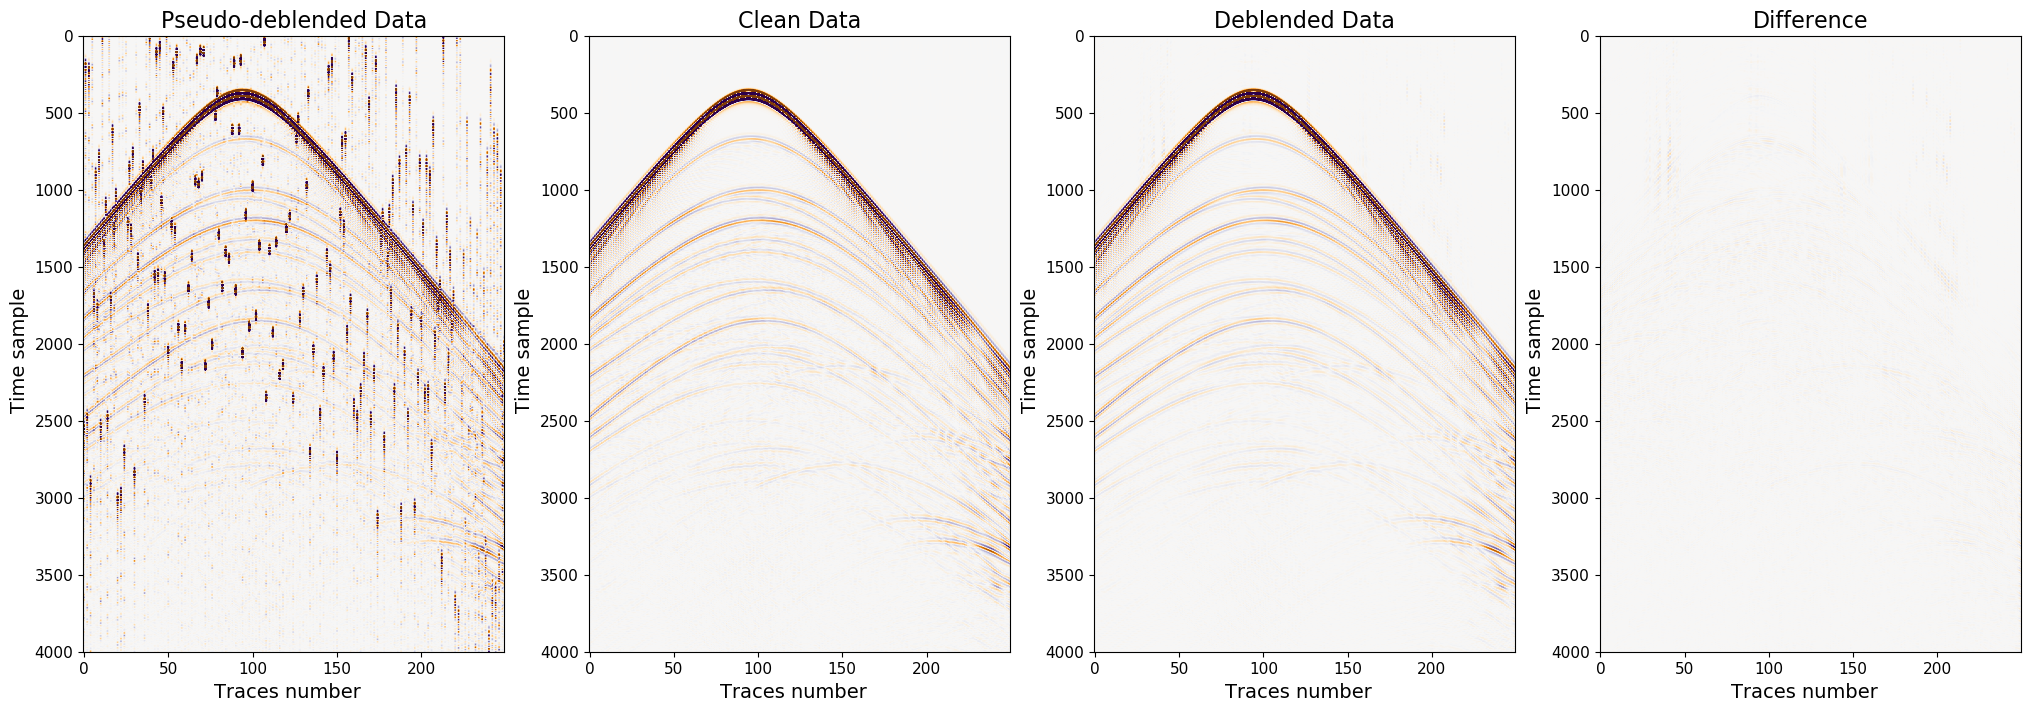

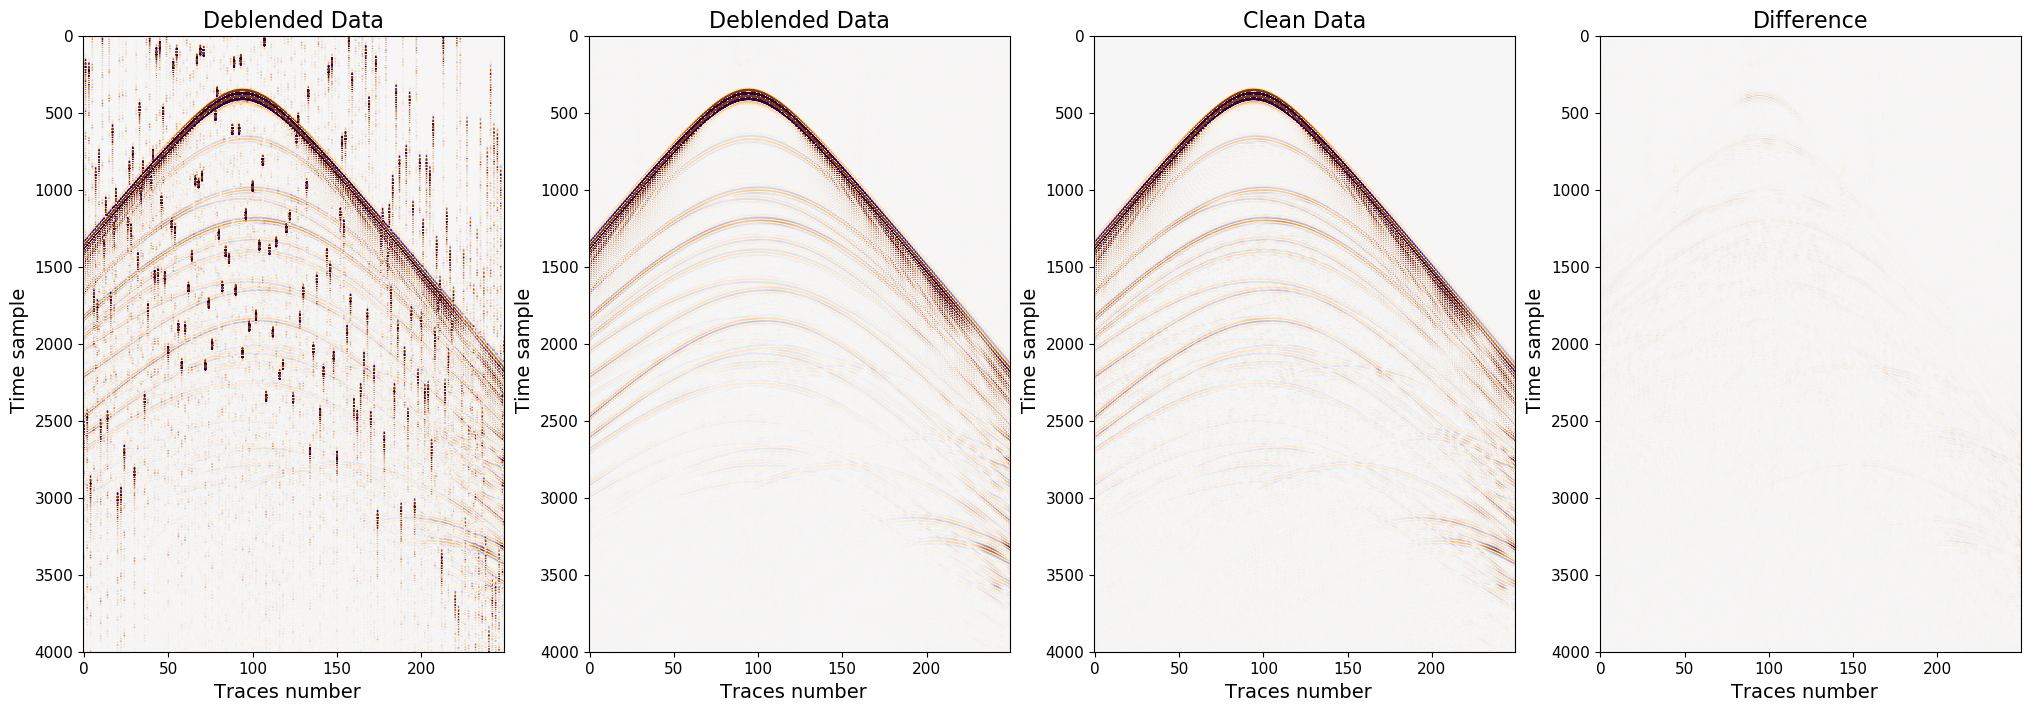

PyObject <matplotlib.image.AxesImage object at 0x7f21db66ff90>

In [8]:
figure(2, figsize=(25, 8))
vm=0.5;
subplot(141);SeisPlotTX(D1[:,45,:], title="Pseudo-deblended Data", fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D[:,45,:],  title="Clean Data", fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D4[:,45,:], title="Deblended Data",     fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D4[:,45,:]-D[:,45,:], title="Difference",fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)

figure(3, figsize=(25, 8))
vm=0.5;
subplot(141);SeisPlotTX(D1[:,45,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D3[:,45,:], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D[:,45,:],  title="Clean Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D3[:,45,:]-D[:,45,:], title="Difference", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
